In [2]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import tensorflow as tf
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

image_types = os.listdir('vehicles/')
vehicles = []
for imtype in image_types:
    vehicles.extend(glob.glob('vehicles/'+imtype+'/*'))

with open('vehicles.txt', 'w') as f:
    for fn in vehicles:
        f.write(fn + '\n')
        
print('Vehicle Images count:', len(vehicles))

image_types = os.listdir('non-vehicles/')
non_vehicles = []
for imtype in image_types:
    non_vehicles.extend(glob.glob('non-vehicles/'+imtype+'/*'))

with open('non_vehicles.txt', 'w') as f:
    for fn in non_vehicles:
        f.write(fn + '\n')
        
print('Non-Vehicle Image count:', len(non_vehicles))

Vehicle Images count: 8792
Non-Vehicle Image count: 8968


In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel() 
    color2 = cv2.resize(img[:,:,1], size).ravel() 
    color3 = cv2.resize(img[:,:,2], size).ravel() 
    # Return the feature vector
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient = 9, pix_per_cell = 8, cell_per_block = 2, hog_channel = 0, spatial_feat = True, hist_feat = True, hog_feat = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else: feature_image = np.copy(image) 
            
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                         orient, pix_per_cell, cell_per_block, 
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=False, feature_vec = True)
                
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def single_img_features(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient = 9, pix_per_cell = 8, 
                        cell_per_block = 2, hog_channel = 0,
                        spatial_feat = True, hist_feat = True,
                        hog_feat = True, vis = False):
    # Create a list to append feature vectors to
    img_features = []
    # Iterate through the list of images
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)     
    
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
        
    if hist_feat == True:
        # Apply bin_spatial() to get spatial color features
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                     orient, pix_per_cell, cell_per_block, 
                                                     vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                                           orient, pix_per_cell, cell_per_block, 
                                                           vis=True, feature_vec = True)
            else: 
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                           orient, pix_per_cell, cell_per_block, 
                                                           vis=False, feature_vec = True)
        img_features.append(hog_features)
    
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
        plt.axis('off')
    plt.show();

In [5]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' #0,1,2 or 'ALL'
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

indices = np.random.randint(0, len(vehicles), 1000)
test_cars = np.array(vehicles)[indices]
test_notcars = np.array(non_vehicles)[indices]

car_features = extract_features(test_cars, color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.1, random_state=rand_state)
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [6]:
import tensorflow as tf
from numpy.random import uniform, randint
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Lambda
from keras.layers import ELU, Convolution2D, MaxPooling2D, Flatten, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
tf.python.control_flow_ops = tf

Using TensorFlow backend.


In [7]:
def neuralnet():
    model = Sequential()
    
    model.add(Dense(100, input_dim=8412))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model = neuralnet()
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch = 40)

Train on 1800 samples, validate on 200 samples
Epoch 1/40
1800/1800 [==============================] - 4s - loss: 0.8882 - acc: 0.7433 - val_loss: 0.0789 - val_acc: 0.9800
Epoch 2/40
1800/1800 [==============================] - 3s - loss: 0.4116 - acc: 0.8767 - val_loss: 0.0620 - val_acc: 0.9800
Epoch 3/40
1800/1800 [==============================] - 4s - loss: 0.2287 - acc: 0.9261 - val_loss: 0.0484 - val_acc: 0.9850
Epoch 4/40
1800/1800 [==============================] - 2s - loss: 0.1345 - acc: 0.9594 - val_loss: 0.0837 - val_acc: 0.9850
Epoch 5/40
1800/1800 [==============================] - 2s - loss: 0.1494 - acc: 0.9628 - val_loss: 0.0712 - val_acc: 0.9850
Epoch 6/40
1800/1800 [==============================] - 2s - loss: 0.1176 - acc: 0.9728 - val_loss: 0.0873 - val_acc: 0.9900
Epoch 7/40
1800/1800 [==============================] - 2s - loss: 0.0908 - acc: 0.9811 - val_loss: 0.0836 - val_acc: 0.9900
Epoch 8/40
1800/1800 [==============================] - 2s - loss: 0.0944 - ac

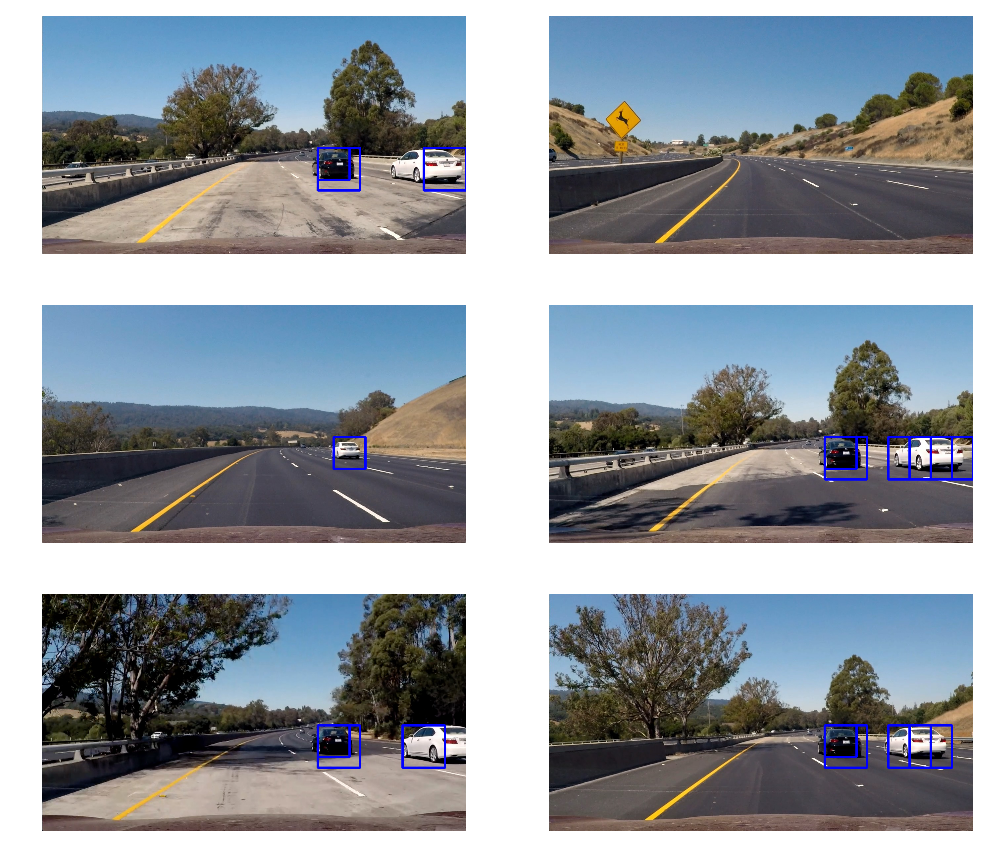

In [10]:
example_images = glob.glob('test_images/*')
titles = []
images = []
y_start_stop = [400, 656] # Min and Max in y to search in slide_window()
overlap = 0.5

for img_src in example_images:
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[400, 1000], y_start_stop=[400, 500],
                          xy_window = (96, 96), xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window = (128, 128), xy_overlap=(overlap, overlap))
    
    hot_windows.extend(search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window = (192, 192), xy_overlap=(overlap, overlap))
    
    hot_windows.extend(search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat))
    
    window_img = draw_boxes(draw_img, hot_windows, color = (0,0,255), thick = 6)
    images.append(window_img)
    titles.append('')
    
fig = plt.figure(figsize=(12, 18), dpi = 300)
visualize(fig, 5, 2, images, titles)

In [11]:
def find_cars(img, scale):
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction1 = svc.predict(test_features)
            test_prediction2 = model.predict(test_features)[0][0]
            
            test_prediction = round(0.5*test_prediction1[0] + 0.5*test_prediction2)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0,0,255))
                #img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart : ytop_draw + win_draw + ystart, xbox_left: xbox_left + win_draw] += 1
                
    return draw_img, heatmap

In [12]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

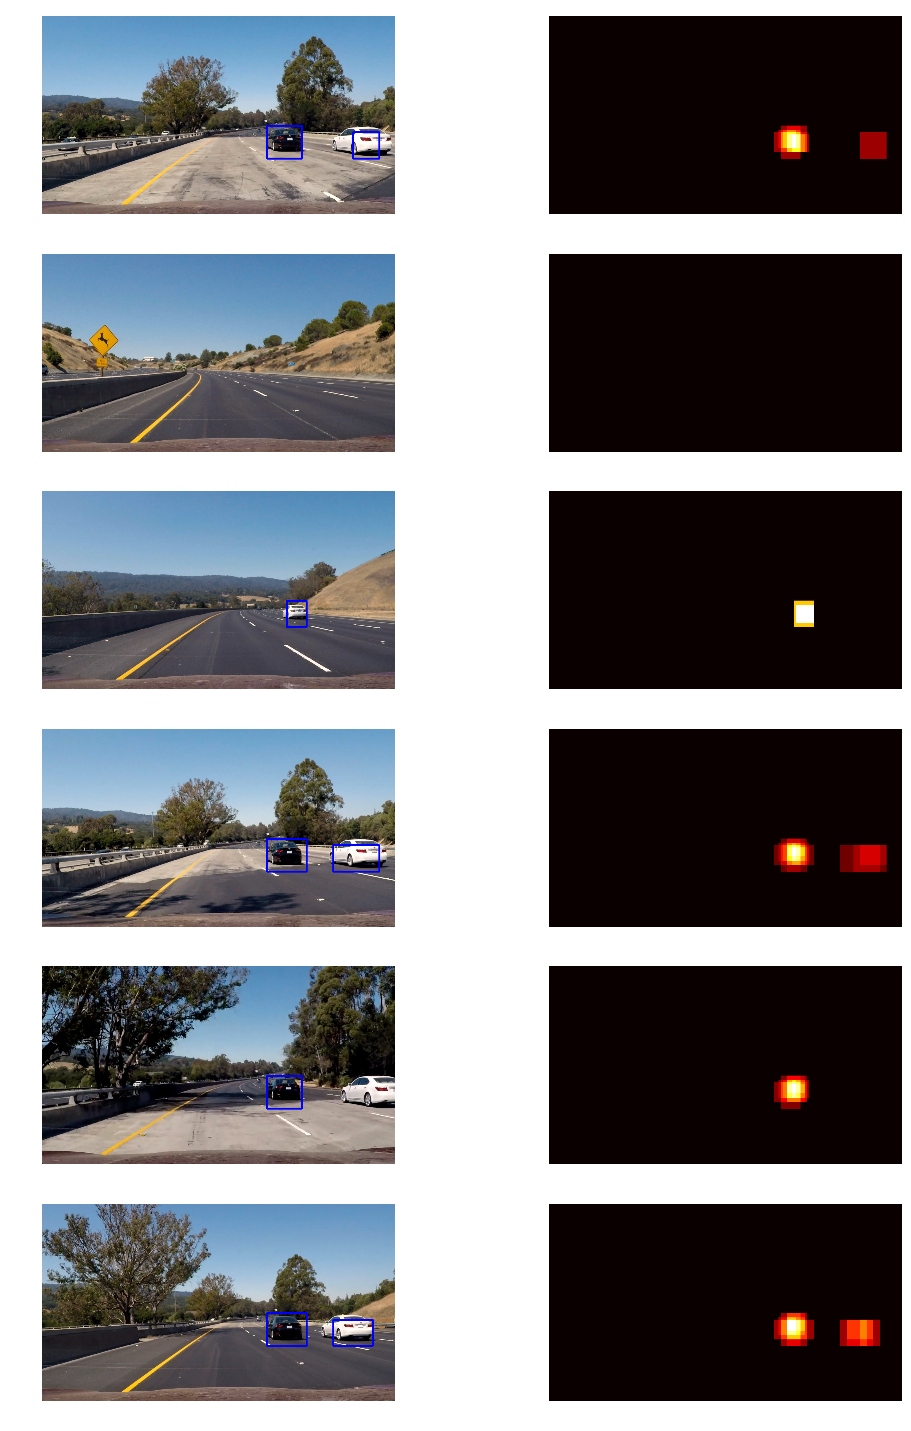

In [13]:
out_images = []
out_maps = []
ystart = 400
ystop = 656

for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map1 = find_cars(img, 1.)
    out_img, heat_map2 = find_cars(img, 1.5)
    heat_map = heat_map1 + heat_map2
    heat_map[heat_map <= 1] = 0
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12, 24))
visualize(fig, 8, 2, out_images, ["","","","","","","","","","","","","","","",""])

In [14]:
last_10_heat_maps = []

def process(img):
    global last_10_heat_maps
    if len(last_10_heat_maps) > 9:
        last_10_heat_maps = last_10_heat_maps[-9:]
        
    out_img, heat_map1 = find_cars(img, 1.0)
    out_img, heat_map2 = find_cars(img, 1.5)
    heat_map = heat_map1 + heat_map2
    
    last_10_heat_maps.append(heat_map)
    heat_map = 0.1*np.sum(last_10_heat_maps, axis = 0)
    heat_map[heat_map <= 1] = 0
    labels = label(np.round(heat_map, decimals = 0))
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'output_video_nn_ensemble.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process)
test_clip.write_videofile(test_output, audio=False)

/Users/Rayno/anaconda3/lib/python3.5/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
/Users/Rayno/anaconda3/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file output_video_nn_ensemble.mp4
----------------------------------------

Writing video into output_video_nn_ensemble.mp4


100%|██████████| 1210/1210 [1:05:41<00:00,  3.26s/it]


Done writing video in output_video_nn_ensemble.mp4 !
Your video is ready !


In [16]:
HTML("""<video width="960" height="540" controls> <source src="{0}"> </video>""".format(test_output))